In [169]:
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd

In [178]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/combined.csv'
df=pd.read_csv(url,index_col='FIPS',encoding="ISO-8859-1")

In [171]:
#read in variable information and build variable information dictionary with variable names as key
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Food_atlas/Var_name_info.csv'
var_info_df=pd.read_csv(url,encoding="ISO-8859-1", index_col='variable')

In [172]:
from sklearn import preprocessing
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

df=df[df.columns.difference(['State','County'])]

In [173]:
df['RUCC_2013']=df['RUCC_2013'].astype(str)

In [174]:
df = pd.get_dummies(df, drop_first=True)

In [175]:
df.shape

(3141, 67)

missing value imputation

In [176]:
#pipeline with missing values imputation and regression
# Import the Imputer module
from sklearn.preprocessing import Imputer, scale
# Setup the Imputation transformer: imp
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_data=imp.fit_transform(df.values)
imp_data.shape
imp_df=pd.DataFrame(imp_data, index=df.index, columns=df.columns)

ValueError: Shape of passed values is (62, 3141), indices imply (67, 3141)

In [136]:
normed_data=scale(imp_df)
normed_df=pd.DataFrame(normed_data, index=imp_df.index, columns=imp_df.columns)

In [137]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

predictors=df.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1)

In [150]:
predictors.columns

Index(['frac_uninsured', 'prevalence of physical inactivity', 'var10', 'var11',
       'var12', 'var13', 'var14', 'var15', 'var16', 'var17', 'var18', 'var19',
       'var2', 'var20', 'var21', 'var22', 'var23', 'var24', 'var27', 'var3',
       'var30', 'var31', 'var32', 'var33', 'var34', 'var35', 'var36', 'var37',
       'var38', 'var39', 'var4', 'var40', 'var44', 'var5', 'var58', 'var59',
       'var6', 'var60', 'var61', 'var62', 'var63', 'var64', 'var65', 'var66',
       'var67', 'var68', 'var69', 'var7', 'var8', 'var9', 'RUCC_2013_2',
       'RUCC_2013_3', 'RUCC_2013_4', 'RUCC_2013_5', 'RUCC_2013_6',
       'RUCC_2013_7', 'RUCC_2013_8', 'RUCC_2013_9'],
      dtype='object')

In [151]:
predictors=predictors[predictors.columns[::-1]]

In [152]:
predictors.columns

Index(['RUCC_2013_9', 'RUCC_2013_8', 'RUCC_2013_7', 'RUCC_2013_6',
       'RUCC_2013_5', 'RUCC_2013_4', 'RUCC_2013_3', 'RUCC_2013_2', 'var9',
       'var8', 'var7', 'var69', 'var68', 'var67', 'var66', 'var65', 'var64',
       'var63', 'var62', 'var61', 'var60', 'var6', 'var59', 'var58', 'var5',
       'var44', 'var40', 'var4', 'var39', 'var38', 'var37', 'var36', 'var35',
       'var34', 'var33', 'var32', 'var31', 'var30', 'var3', 'var27', 'var24',
       'var23', 'var22', 'var21', 'var20', 'var2', 'var19', 'var18', 'var17',
       'var16', 'var15', 'var14', 'var13', 'var12', 'var11', 'var10',
       'prevalence of physical inactivity', 'frac_uninsured'],
      dtype='object')

In [154]:
X=predictors.values
y_db=df['prevalence of diabetes'].values
y_ob=df['prevalence of obesity'].values

In [155]:
from sklearn.linear_model import ElasticNetCV
X_train, X_test, y_train, y_test = train_test_split(X, y_db, test_size=0.25, random_state=42)
#alphas=[0, 0.0001, 0.001, .1, 1, 10, 100]
regr_db = ElasticNetCV(cv=5, random_state=0, 
                    l1_ratio=[0.1,0.3,0.4, 0.5,0.55, 0.6, 0.65, 0.75, 0.8, 0.9,1], max_iter=5000, n_alphas=5000, normalize=True)
regr_db.fit(X_train, y_train)
#ElasticNetCV(alphas=[0.1, 1, 10, 100], copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       #l1_ratio=1, max_iter=5000, n_alphas=5000, n_jobs=5,
       #normalize=True, positive=False, precompute='auto', random_state=42,
       #selection='cyclic', tol=0.0001, verbose=0)
print(regr_db.alpha_) 
print (regr_db.l1_ratio_)
print(regr_db.intercept_) 
r2 = regr_db.score(X_test,y_test)
print (r2)

0.000142937354545
1.0
1.95758952925
0.776343350361


plot coefficients

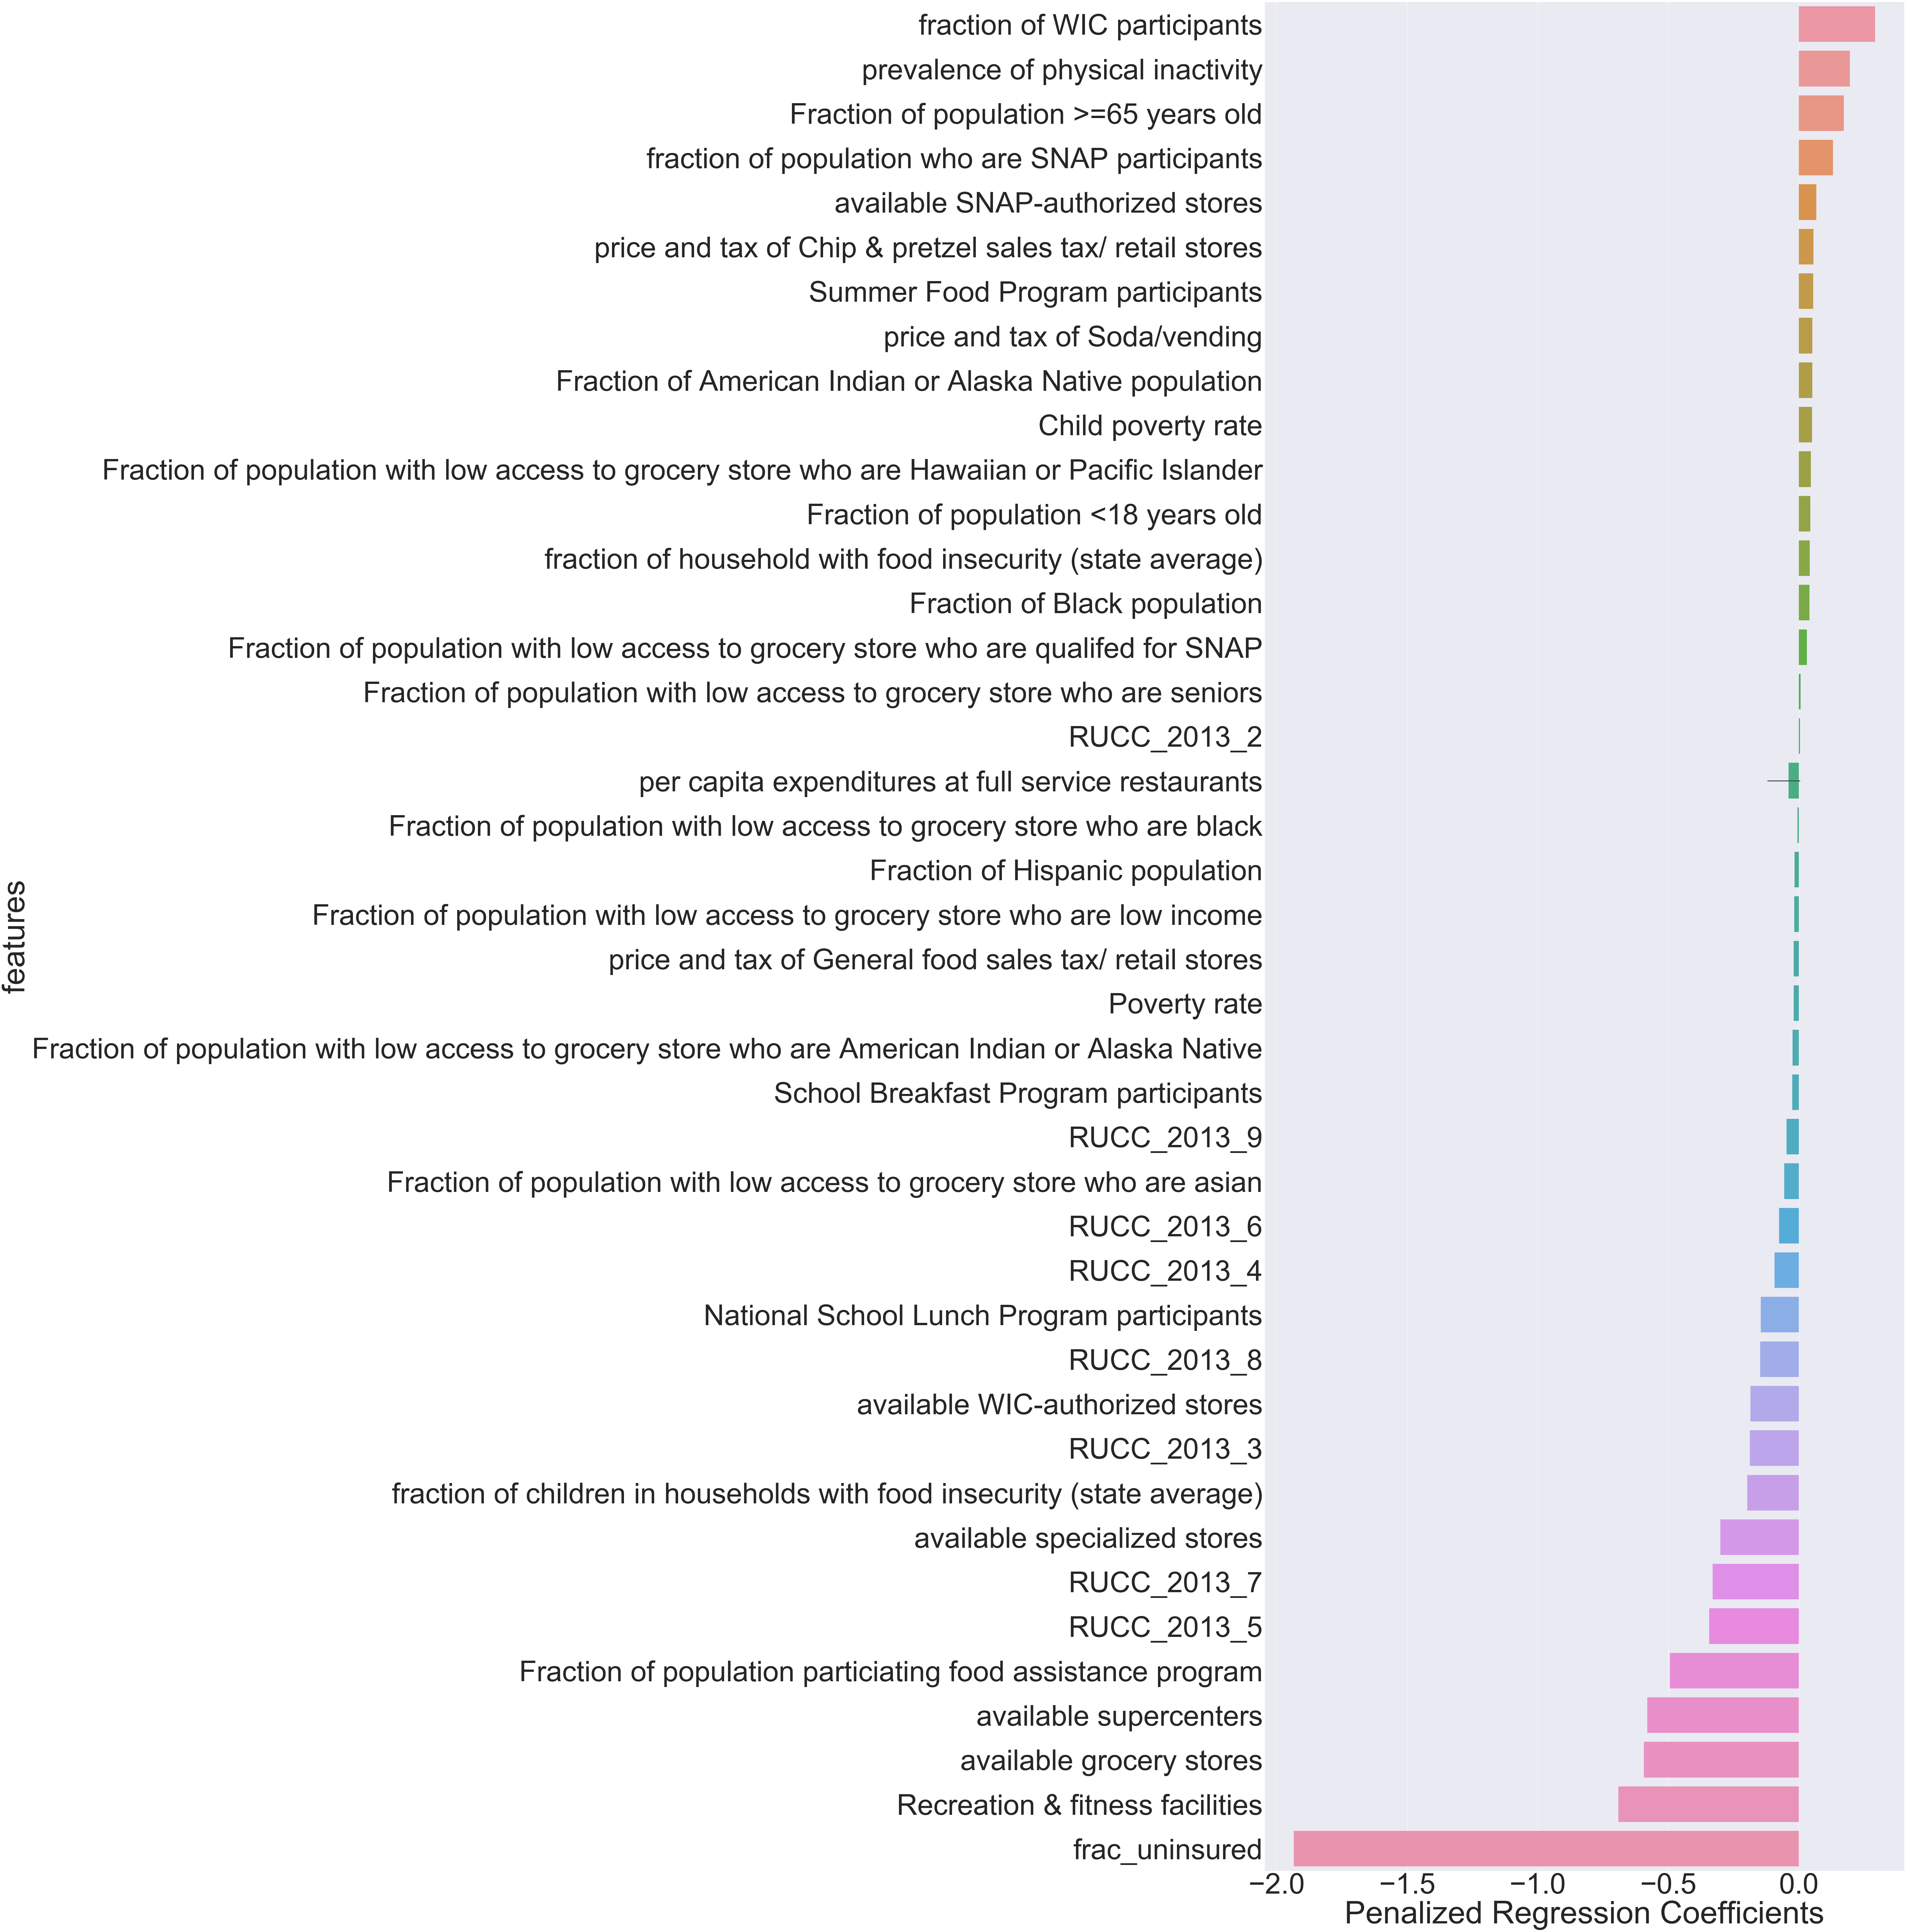

In [177]:
import seaborn as sns


coef_db = pd.DataFrame(np.round_(regr_db.coef_, decimals=3), columns = ["coefficients"])
coef_db['features']=[var_info_df.loc[c]['meaning'] if c in var_info_df.index else c for c in predictors.columns]
# remove the zero coefficients
coef_db = coef_db[coef_db['coefficients'] != 0]
# sort the values from high to low
coef_db = coef_db.sort_values(by = 'coefficients', ascending = False)

coef_db['group']=['diabetes' for n in range(len(coef_db.index))]

# plot the sorted dataframe
plt.figure(figsize=(40,120))
ax = sns.barplot(x = 'coefficients', y= coef_db['features'] , data=coef_db)
ax.set(xlabel='Penalized Regression Coefficients')
sns.set(font_scale = 10)
plt.show()


In [56]:
df_pred=pd.DataFrame()
df_pred=imp_df.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1)
df_pred['prevalence of physical inactivity']=df_pred['prevalence of physical inactivity'].apply((lambda x:x*0.9))


regr.fit(X_train,y_train)
print (elastic_net.coef_)
X_new=df_pred.values
pred=regr.predict(X_new)  
print (pred)
print (y)

[ -1.88993009e+00   1.93889137e-01  -7.40503114e-02  -2.54469975e-02
   1.15509615e-01  -0.00000000e+00  -6.04973328e-01  -7.84168587e-01
  -1.09213802e-03  -3.33744094e-01   8.74142628e-02  -2.13133900e-01
  -2.26326789e-02  -0.00000000e+00  -1.20320751e-01   3.41035969e-03
  -2.93236839e-03   1.28499785e-01  -1.52736225e-01   0.00000000e+00
  -3.50656362e-02   6.94378957e-02   3.13668232e-01  -4.83333764e-01
   4.33035425e-02   7.59191267e-03  -1.99766639e-01   0.00000000e+00
   5.04886699e-02   6.52158544e-02   3.51005809e-02  -2.60035324e-02
  -0.00000000e+00  -0.00000000e+00  -7.10560511e-01  -0.00000000e+00
   1.43090889e-02   3.99740097e-02  -1.73499525e-02  -0.00000000e+00
   5.16794606e-02   0.00000000e+00   1.68549769e-01   4.44676198e-02
  -2.60015646e-06  -2.18615567e-02   5.06275286e-02   0.00000000e+00
  -7.09580045e-03   4.02788589e-04  -0.00000000e+00  -2.19856649e-01
  -1.29147097e-01  -3.81843097e-01  -1.06211805e-01  -3.61426375e-01
  -1.86068650e-01  -8.09213139e-02

Set outcome as obesity

In [141]:
from sklearn.linear_model import ElasticNetCV
X_train, X_test, y_train, y_test = train_test_split(X, y_ob, test_size=0.25, random_state=42)
#alphas=[0, 0.0001, 0.001, .1, 1, 10, 100]
regr_ob = ElasticNetCV(cv=5, random_state=0, 
                    l1_ratio=[0.1,0.3,0.4, 0.5,0.55, 0.6, 0.65, 0.75, 0.8, 0.9,1], max_iter=5000, n_alphas=5000, normalize=True)
regr_ob.fit(X_train, y_train)
#ElasticNetCV(alphas=[0.1, 1, 10, 100], copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       #l1_ratio=1, max_iter=5000, n_alphas=5000, n_jobs=5,
       #normalize=True, positive=False, precompute='auto', random_state=42,
       #selection='cyclic', tol=0.0001, verbose=0)
print(regr_ob.alpha_) 
print (regr_ob.l1_ratio_)
print(regr_ob.intercept_) 
r2 = regr_ob.score(X_test,y_test)
print (r2)

7.35967315802e-05
0.9
35.1988709817
0.668056339011


plot coefficients

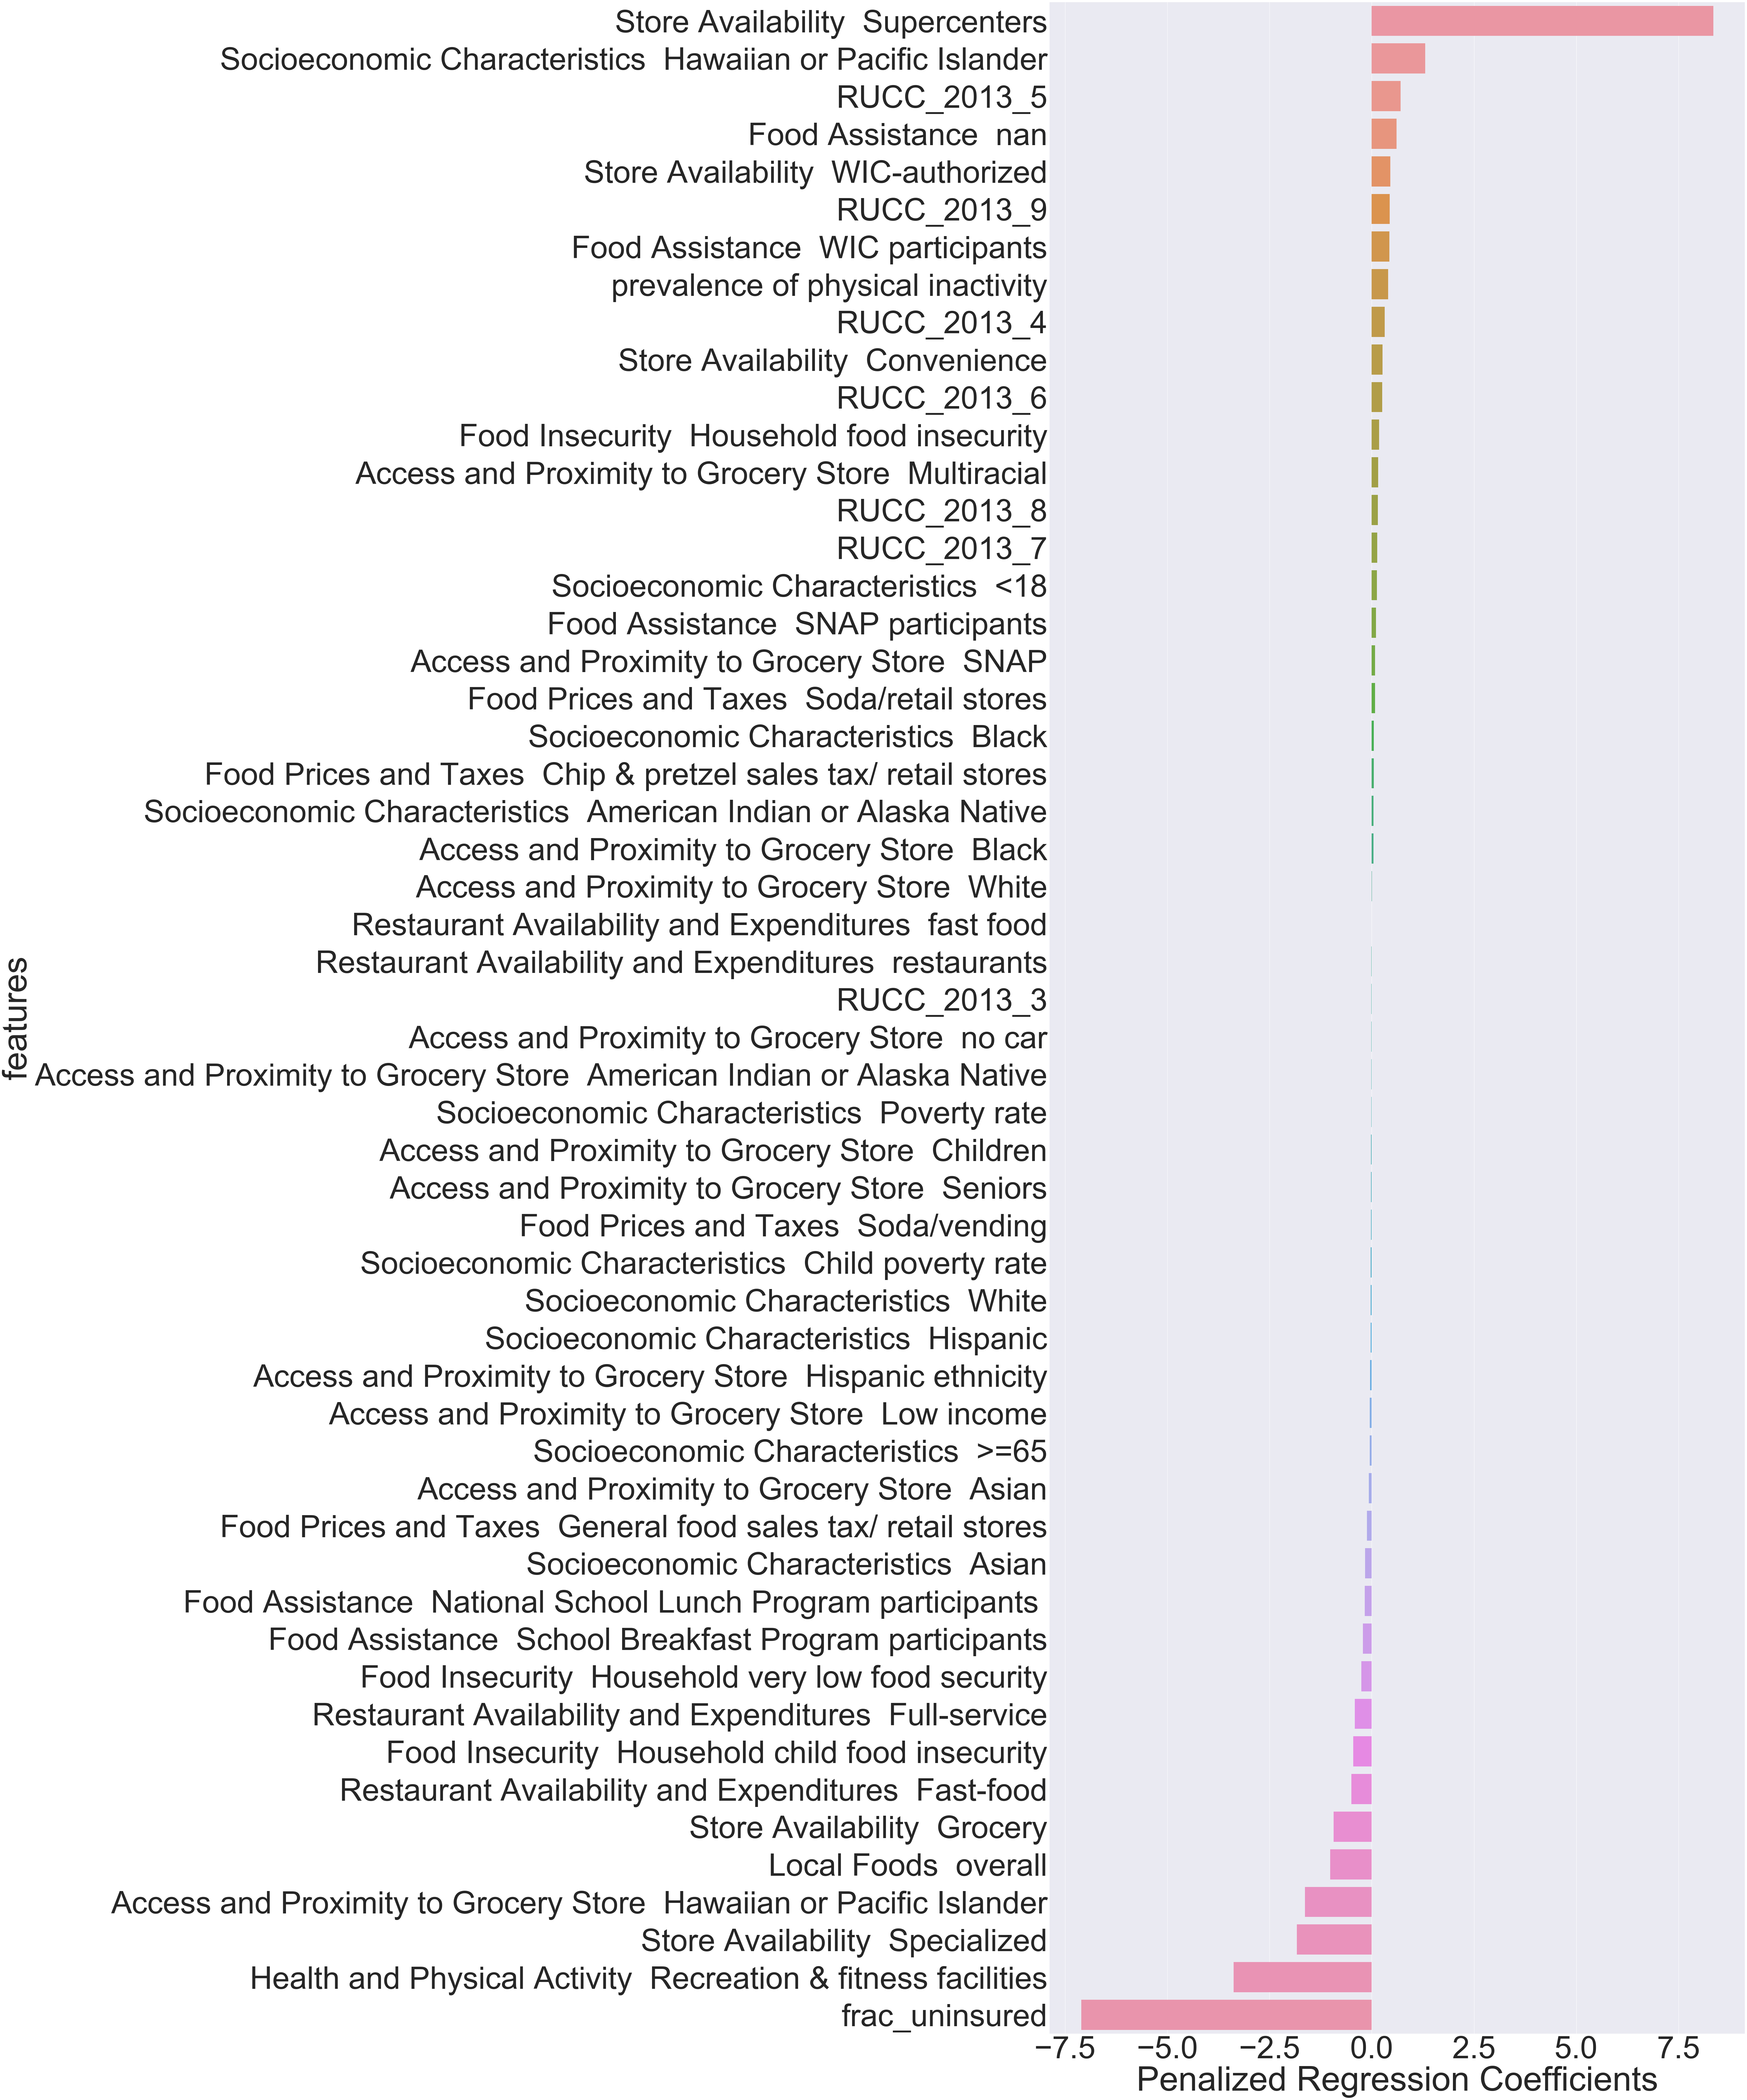

In [144]:
import seaborn as sns


coef_ob = pd.DataFrame(np.round_(regr_ob.coef_, decimals=3), columns = ["coefficients"])
coef_ob['features']==[var_info_df.loc[c]['meaning'] if c in var_info_df.index else c for c in predictors.columns]
# remove the zero coefficients
coef_ob = coef_ob[coef_ob['coefficients'] != 0]
# sort the values from high to low
coef_ob = coef_ob.sort_values(by = 'coefficients', ascending = False)

coef_ob['group']=['obesity' for n in range(len(coef_ob.index))]

# plot the sorted dataframe
plt.figure(figsize=(40,120))
ax = sns.barplot(x = 'coefficients', y= 'features' , data=coef_ob)
ax.set(xlabel='Penalized Regression Coefficients')
sns.set(font_scale = 10)
plt.show()


In [145]:
coefs=pd.concat([coef_db,coef_ob], axis=0)

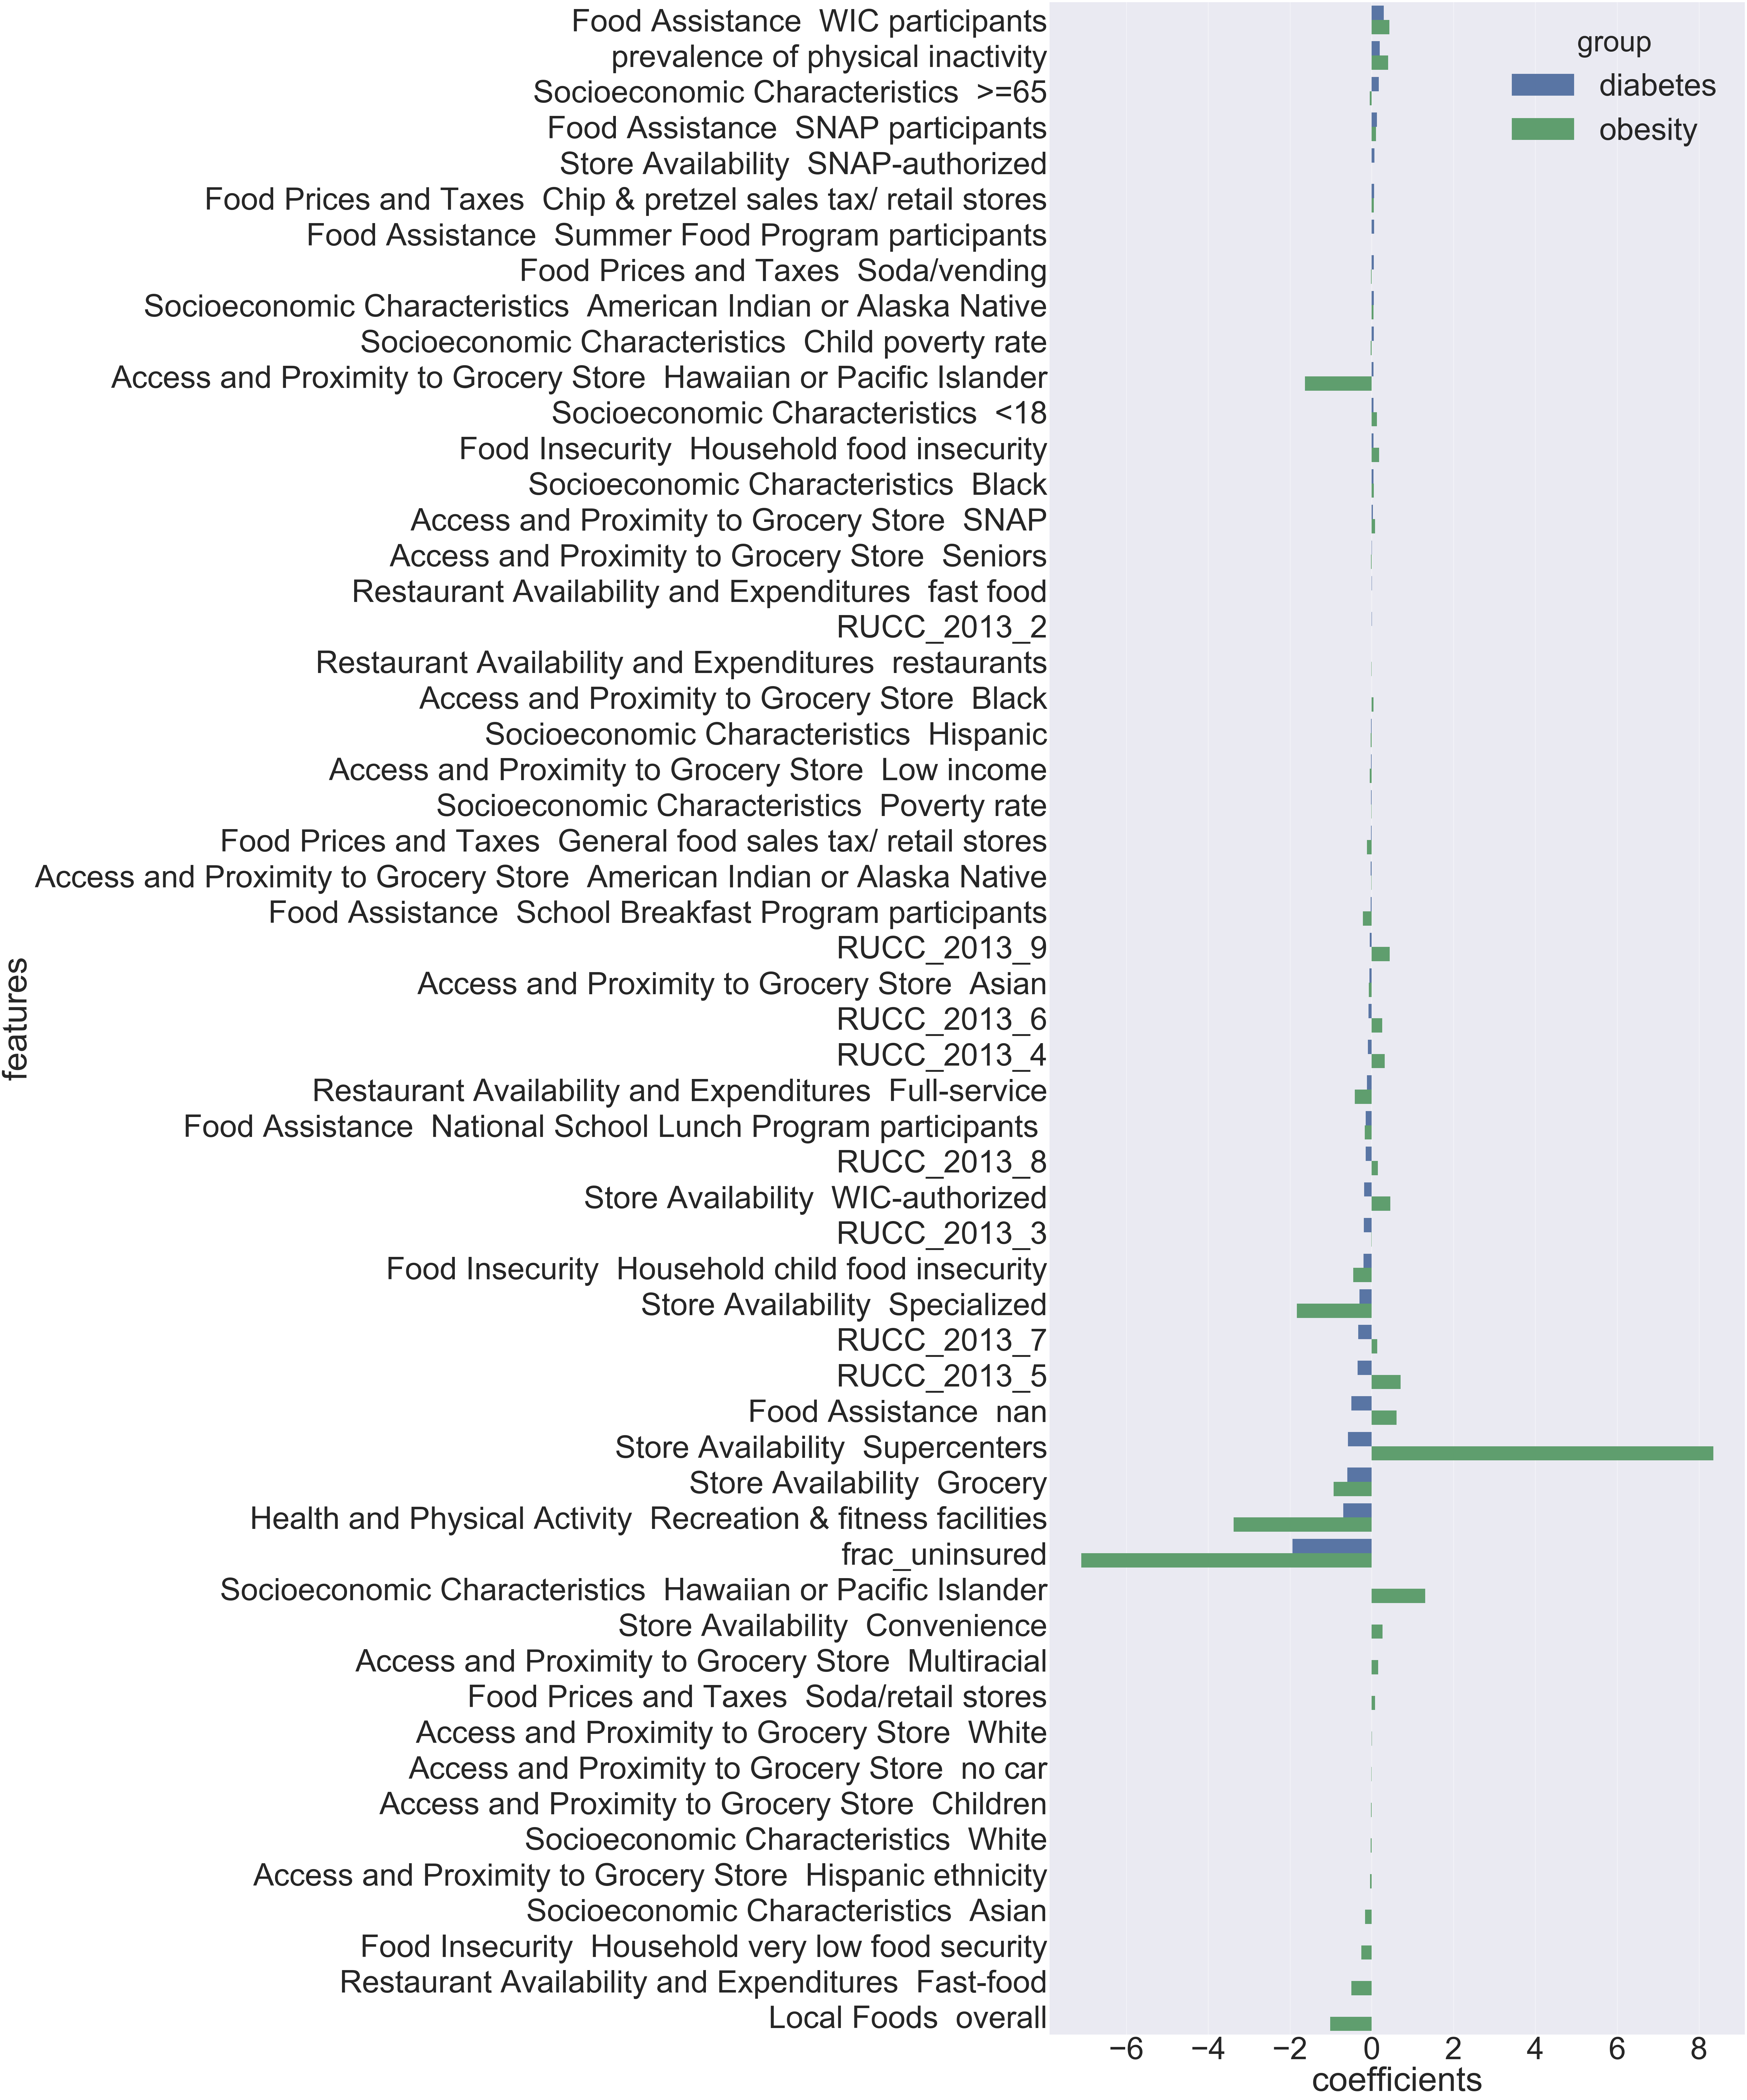

In [149]:
plt.figure(figsize=(40,120))
ax = sns.barplot(x = 'coefficients', y= 'features' , data=coefs, hue='group')
sns.set(font_scale = 8)
plt.show()